In [ ]:
import torch.nn as nn
import torch
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from torchvision import transforms
from PIL import Image
from IPython.display import display, clear_output
from io import BytesIO

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 18 * 18, 64),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def load_model(model_path, device="cpu"):
    model = CNN()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [ ]:
def preprocess_image(image, img_size=150):
    transform = transforms.Compose(
        [transforms.Resize((img_size, img_size)), transforms.ToTensor()]
    )

    if isinstance(image, str):
        image = Image.open(image).convert("RGB")
    else:
        image = image.convert("RGB")

    original_image = image.copy()
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)

    return input_batch, original_image




In [ ]:
def predict_image(model, image_tensor, device="cpu", threshold=0.5):
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        probability = output.item()

        if probability > threshold:
            predicted_class = "human"
        else:
            predicted_class = "horse"

        return predicted_class, probability


def visualize_prediction(image, prediction, probability):
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")

    title = f"Prediction: {prediction}\nProbability: {probability:.3f}"
    plt.title(title, fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


def process_uploaded_image(change):
    clear_output(wait=True)

    display(upload_button)

    if upload_button.value:
        uploaded_file = upload_button.value[0]

        uploaded_filename = uploaded_file.name
        image_data = uploaded_file.content

        image = Image.open(BytesIO(image_data))

        image_tensor, original_image = preprocess_image(image)

        predicted_class, probability = predict_image(model, image_tensor, device)

        print(f"Обрабатывается: {uploaded_filename}")
        print(f"Размер изображения: {original_image.size}")
        visualize_prediction(original_image, predicted_class, probability)


def upload_image_directly():
    file_path_input = widgets.Text(
        placeholder="Введите путь к файлу",
        description="Путь:",
        layout=widgets.Layout(width="80%"),
    )

    process_button = widgets.Button(description="Обработать", button_style="primary")

    output = widgets.Output()

    def on_process_button_clicked(b):
        with output:
            clear_output()
            file_path = file_path_input.value.strip()
            if file_path:
                try:
                    image_tensor, original_image = preprocess_image(file_path)

                    predicted_class, probability = predict_image(
                        model, image_tensor, device
                    )

                    print(f"Обрабатывается: {file_path}")
                    print(f"Размер изображения: {original_image.size}")
                    visualize_prediction(original_image, predicted_class, probability)
                except Exception as e:
                    print(f"Ошибка при обработке изображения: {e}")
            else:
                print("Введите путь к файлу")

    process_button.on_click(on_process_button_clicked)

    display(
        widgets.VBox(
            [
                widgets.HTML("<h3>Загрузка изображения по пути:</h3>"),
                widgets.HBox([file_path_input, process_button]),
                output,
            ]
        )
    )

FileUpload(value=({'name': 'i.webp', 'type': 'image/webp', 'size': 10638, 'content': <memory at 0x0000026D4580…

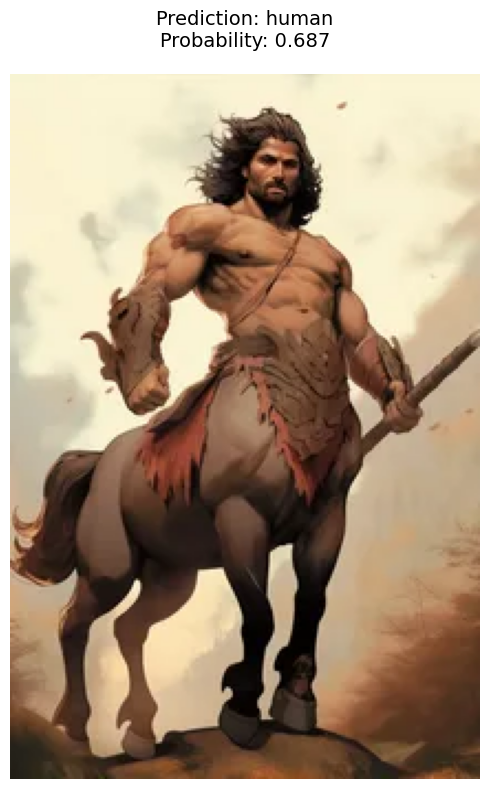

In [ ]:
models_path = "models"

MODEL_PATH = os.path.join(models_path, "model.pth")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = load_model(MODEL_PATH, device)

print("Модель загружена успешно!")
print(f"Используется устройство: {device}")

upload_button = widgets.FileUpload(
    accept="image/*",
    multiple=False,
    description="Выберите файл",
    button_style="primary",
)

upload_button.observe(process_uploaded_image, names="value")

print("\n" + "=" * 50)
print("ВЫБЕРИТЕ СПОСОБ ЗАГРУЗКИ ИЗОБРАЖЕНИЯ:")
print("=" * 50 + "\n")

display(widgets.HTML("<h3>1. Загрузка через кнопку:</h3>"))
display(upload_button)
print("\n")

upload_image_directly()

print("\n" + "=" * 50)
instructions = widgets.Accordion(
    children=[
        widgets.HTML(
            """
    <h4>Инструкция:</h4>
    <ol>
    <li><strong>Способ 1:</strong> Нажмите на кнопку "Выберите файл" и выберите изображение с компьютера</li>
    <li><strong>Способ 2:</strong> Введите полный путь к файлу в текстовое поле и нажмите "Обработать"</li>
    </ol>
    <p><em>Поддерживаемые форматы: JPEG, PNG, GIF, BMP и другие</em></p>
    """
        )
    ]
)
instructions.set_title(0, "Показать инструкцию")
display(instructions)